# Human Resources Analytics

**My goal is to understand what factors contribute most to employee turnover and create a model that can predict if a certain employee will leave the company or not**

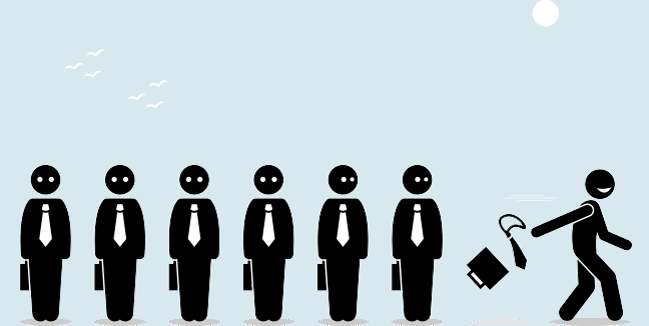

**Obtaining and Scrubbing the Data**

In [ ]:
# Import the neccessary libraries for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv("/kaggle/input/hr-analytics/HR_comma_sep.csv")

In [ ]:
df.isnull().any()

In [ ]:
df.head()

In [ ]:
# Renaming certain columns for better readability
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

In [ ]:
# Move the reponse variable "turnover" to the front of the table
front = df['turnover']
df.drop(labels=['turnover'], axis=1,inplace = True)
df.insert(0, 'turnover', front)
df.head()

# Exploring the Data

**Statistical Overview**

In [ ]:
df.shape

In [ ]:
# Check the type of our features. 
df.dtypes

In [ ]:
turnover_rate = df.turnover.value_counts() / 14999
turnover_rate

In [ ]:
# Display the statistical overview of the employees
df.describe()

The dataset has:

About 15,000 employee observations and 10 features

The company had a turnover rate of about 24%

Mean satisfaction of employees is 0.61

In [ ]:
# Overview of summary (Turnover V.S. Non-turnover)
turnover_Summary = df.groupby('turnover')
turnover_Summary.mean()

**Correlation Matrix & Heatmap**

In [ ]:
#Correlation Matrix
corr = df.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

**Statistical Test for Correlation**

In [ ]:
# Let's compare the means of our employee turnover satisfaction against the employee population satisfaction
emp_population_satisfaction = df['satisfaction'].mean()
emp_turnover_satisfaction = df[df['turnover']==1]['satisfaction'].mean()

print( 'The mean for the employee population is: ' + str(emp_population_satisfaction) )
print( 'The mean for the employees that had a turnover is: ' + str(emp_turnover_satisfaction) )


**Conducting the T-Test**

In [ ]:
import scipy.stats as stats
stats.ttest_1samp(a=  df[df['turnover']==1]['satisfaction'], # Sample of Employee satisfaction who had a Turnover
                  popmean = emp_population_satisfaction)  # Employee Population satisfaction mean

The test result shows the test statistic "t" is equal to -39.109. This test statistic tells us how much the sample mean deviates from the null hypothesis. If the t-statistic lies outside the quantiles of the t-distribution corresponding to our confidence level and degrees of freedom, we reject the null hypothesis. We can check the quantiles with stats.t.ppf():

In [ ]:
degree_freedom = len(df[df['turnover']==1])

LQ = stats.t.ppf(0.025,degree_freedom)  # Left Quartile

RQ = stats.t.ppf(0.975,degree_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(LQ))
print ('The t-distribution right quartile range is: ' + str(RQ))

Based on the statistical analysis of a one sample t-test, there seems to be some significant difference between the mean satisfaction of employees who had a turnover and the entire employee population. The super low P-value of 9.012e-279 at a 5% confidence level is a good indicator to reject the null hypothesis.

**Distribution Plots (Satisfaction - Evaluation - AverageMonthlyHours)**

In [ ]:
# Set up the matplotlib figure
f, axes = plt.subplots(ncols=3, figsize=(15, 6))

# Graph Employee Satisfaction
sns.distplot(df.satisfaction, kde=False, color="g", ax=axes[0]).set_title('Employee Satisfaction Distribution')
axes[0].set_ylabel('Employee Count')

# Graph Employee Evaluation
sns.distplot(df.evaluation, kde=False, color="r", ax=axes[1]).set_title('Employee Evaluation Distribution')
axes[1].set_ylabel('Employee Count')

# Graph Employee Average Monthly Hours
sns.distplot(df.averageMonthlyHours, kde=False, color="b", ax=axes[2]).set_title('Employee Average Monthly Hours Distribution')
axes[2].set_ylabel('Employee Count')

**Salary V.S. Turnover**

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salary", hue='turnover', data=df).set_title('Employee Salary Turnover Distribution');


Majority of employees who left either had low or medium salary. Barely any employees left with high salary. Employees with low to average salaries tend to leave the company.

**Department V.S. Turnover**

In [ ]:
# Types of colors
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']

# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='Department', data=df, palette=color_types).set_title('Employee Department Distribution');
 
# Rotate x-labels
plt.xticks(rotation=-45)

The sales, technical, and support department were the top 3 departments to have employee turnover. The management department had the smallest amount of turnover

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="Department", hue='turnover', data=df).set_title('Employee Department Turnover Distribution');

**Turnover V.S. ProjectCount**

In [ ]:
ax = sns.barplot(x="projectCount", y="projectCount", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

More than half of the employees with 2,6, and 7 projects left the company. Majority of the employees who did not leave the company had 3,4, and 5 projects. All of the employees with 7 projects left the company. There is an increase in employee turnover rate as project count increases

**Turnover V.S. Evaluation**

In [ ]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'evaluation'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'evaluation'] , color='r',shade=True, label='turnover')
plt.title('Employee Evaluation Distribution - Turnover V.S. No Turnover')


There is a biomodal distribution for those that had a turnover. Employees with low performance tend to leave the company more. Employees with high performance tend to leave the company more. The sweet spot for employees that stayed is within 0.6-0.8 evaluation

**Turnover V.S. AverageMonthlyHours**

In [ ]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'averageMonthlyHours'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'averageMonthlyHours'] , color='r',shade=True, label='turnover')
plt.title('Employee AverageMonthly Hours Distribution - Turnover V.S. No Turnover')

Another bi-modal distribution for employees that turnovered. Employees who had less hours of work ( ~150 hours or less) left the company more. Employees who had too many hours of work ( ~250 or more) left the company. Employees who left generally were underworked or overworked.

**Turnover V.S. Satisfaction**

In [ ]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'satisfaction'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'satisfaction'] , color='r',shade=True, label='turnover')
plt.title('Employee Satisfaction Distribution - Turnover V.S. No Turnover')

There is a tri-modal distribution for employees that turnovered. Employees who had really low satisfaction levels (0.2 or less) left the company more. Employees who had low satisfaction levels (0.3~0.5) left the company more. Employees who had really high satisfaction levels (0.7 or more) left the company more

**ProjectCount VS AverageMonthlyHours**

In [ ]:
#ProjectCount VS AverageMonthlyHours [BOXPLOT]
#Looks like the average employees who stayed worked about 200hours/month. Those that had a turnover worked about 250hours/month and 150hours/month

import seaborn as sns
sns.boxplot(x="projectCount", y="averageMonthlyHours", hue="turnover", data=df)

As project count increased, so did average monthly hours. Something weird about the boxplot graph is the difference in averageMonthlyHours between people who had a turnver and did not. Looks like employees who did not have a turnover had consistent averageMonthlyHours, despite the increase in projects. In contrast, employees who did have a turnover had an increase in averageMonthlyHours with the increase in projects.

**ProjectCount VS Evaluation**

In [ ]:
import seaborn as sns
sns.boxplot(x="projectCount", y="evaluation", hue="turnover", data=df)

This graph looks very similar to the graph above. What I find strange with this graph is with the turnover group. There is an increase in evaluation for employees who did more projects within the turnover group. But, again for the non-turnover group, employees here had a consistent evaluation score despite the increase in project counts.

**Satisfaction VS Evaluation**

In [ ]:
sns.lmplot(x='satisfaction', y='evaluation', data=df, fit_reg=False, hue='turnover')

There are 3 distinct clusters for employees who left the company

Cluster 1 (Hard-working and Sad Employee): Satisfaction was below 0.2 and evaluations were greater than 0.75. Which could be a good indication that employees who left the company were good workers but felt horrible at their job.

Cluster 2 (Bad and Sad Employee): Satisfaction between about 0.35 ~ 0.45 and evaluations below ~0.58. This could be seen as employees who were badly evaluated and felt bad at work.

Cluster 3 (Hard-working and Happy Employee): Satisfaction between 0.7 ~ 1.0 and evaluations were greater than 0.8. Which could mean that employees in this cluster were "ideal". They loved their work and were evaluated highly for their performance.

**Turnover V.S. YearsAtCompany**

In [ ]:
ax = sns.barplot(x="yearsAtCompany", y="yearsAtCompany", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

More than half of the employees with 4 and 5 years left the company. Employees with 5 years should highly be looked into

**K-Means Clustering of Employee Turnover**

In [ ]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['red' if c == 0 else 'blue' if c == 2 else 'green' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x="satisfaction",y="evaluation", data=df[df.turnover==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Employee Turnover")
plt.show()

Cluster 1 (Blue): Hard-working and Sad Employees.

Cluster 2 (Red): Bad and Sad Employee.

Cluster 3 (Green): Hard-working and Happy Employee

**WORK IN PROGRESS...**